In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
for data in dataset[0].take(4):
  print(data)
  break

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):


  DATASET_SIZE = len(dataset)


  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))


  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))






  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset



In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1


#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()),
            list( val_dataset.take(1).as_numpy_iterator()),
      list( test_dataset.take(1).as_numpy_iterator()))





[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [7]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

**Dataset Visualization**

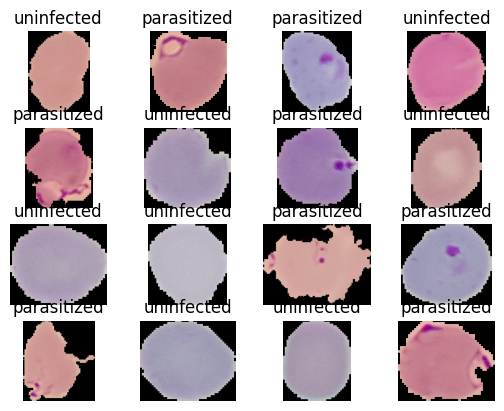

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [9]:
dataset_info.features['label'].int2str(1)

'uninfected'

**Data Preprocessing**

In [10]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [11]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image,label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Model Creation**

In [15]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),


    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),


    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),


    Flatten(),


    Dense(100, activation = "relu"),
    BatchNormalization(),


    Dense(10, activation = "relu"),
    BatchNormalization(),


    Dense(1, activation = "sigmoid"),
    BatchNormalization()

])
lenet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [16]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)


<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [19]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy'
                    )



In [ ]:
history = lenet_model.fit(train_dataset, validation_data = val_dataset, epochs = 20, verbose = 1)

Epoch 1/20
645/689 [===========================>..] - ETA: 48s - loss: 0.3313 - accuracy: 0.9012

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

**Model Evaluation and Testing**

In [24]:
test_dataset = test_dataset.batch(1)

In [25]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 67s 19ms/step - loss: 1.6758 - accuracy: 0.5988


[1.6757811307907104, 0.5988393425941467]

In [30]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 14s 14s/step


'U'

In [29]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 33ms/step


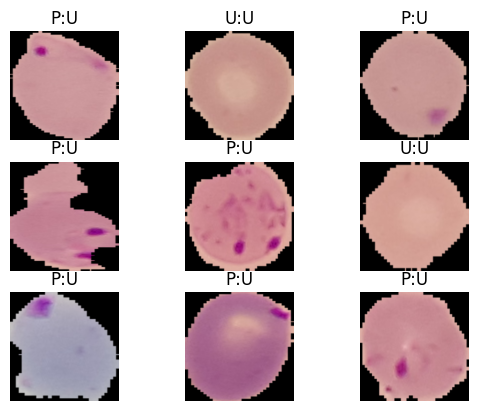

In [32]:
for i, (image, label) in enumerate (test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')

**Corrective Measures**